In [265]:
import logging

import numpy as np
import xgboost as xgb
import talib
from binance.enums import HistoricalKlinesType
from matplotlib import pyplot as plt
from sklearn import metrics
from sklearn.model_selection import train_test_split

from main_funcs import get_and_update_data

In [266]:
# configs
country=None
joft = "ETHUSDT"
interval = "3d"

# remove small candle 
zero_remover_pct = 0.00

# add history of open_close_pct 
open_close_pct_history_count = 40

# add history of max_low_high_pct 
max_low_high_pct_history_count = 40

# calculate rsi with different lengths 
rsi_ranges = range(14, 14)

# add history of rsi
rsi_history_count = 60

# add moving average of rsi
rsi_ma_lengths = [3,7,9,10,14,20,50,100]
rsi_ma_ranges = []


In [267]:
# validation config

# valid rsi_ma_ranges
for r in  rsi_ma_ranges:
    if not r in rsi_ranges:
        raise ValueError("rsi_ma_ranges items is not in rsi_ranges")

In [268]:
# get data from database
df_source = get_and_update_data(joft, interval, HistoricalKlinesType.SPOT, country=country)
df_source = df_source[["open", "high", "low", "close", "volume"]]
# df_source.tail(1)

In [269]:
# calculate parameters
df_cal = df_source.copy()

# change from open to other columns
df_cal['open_close'] = df_cal.close - df_cal.open
df_cal['open_low'] = df_cal.low - df_cal.open
df_cal['open_high'] = df_cal.high - df_cal.open

# change percent from open to other columns
df_cal['open_close_pct'] = df_cal.open_close / df_cal.open
df_cal['open_low_pct'] = df_cal.open_low / df_cal.open
df_cal['open_high_pct'] = df_cal.open_high / df_cal.open

# price direction
# df_target['open_close_direction'] = np.sign(df_target["open_close"])
# df_target['open_open_high_direction'] = np.sign(df_target["open_low"]).astype(int)
# df_target['open_high_direction'] = np.sign(df_target["open_high"]).astype(int)

# max abs low and high
df_cal['max_low_high_pct'] = np.where(
    df_cal['open_low_pct'].abs() > df_cal['open_high_pct'].abs(),
    df_cal['open_low_pct'],
    df_cal['open_high_pct']
)

# open_close_pct history
for h in range(0,open_close_pct_history_count+1):
    df_cal[f"open_close_pct__{h}"] = df_cal.open_close_pct.shift(h)
    

# max_low_high_pct history
for h in range(0,max_low_high_pct_history_count+1):
    df_cal[f"max_low_high_pct__{h}"] = df_cal.max_low_high_pct.shift(h)
    

# calculate multi rsi
for rsi in rsi_ranges:
    for h in range(0, rsi_history_count + 1):
        df_cal[f"rsi_{rsi}__{h}"] = talib.RSI(df_cal.close.shift(h), timeperiod=rsi)
        
# calculate rsi sma 
for ma_length in rsi_ma_lengths:
    for rsi in rsi_ma_ranges:
        df_cal[f"rsi_{rsi}_ma_{ma_length}"] =  talib.SMA(df_cal[f"rsi_{rsi}__{0}"], timeperiod=ma_length)
# df_cal

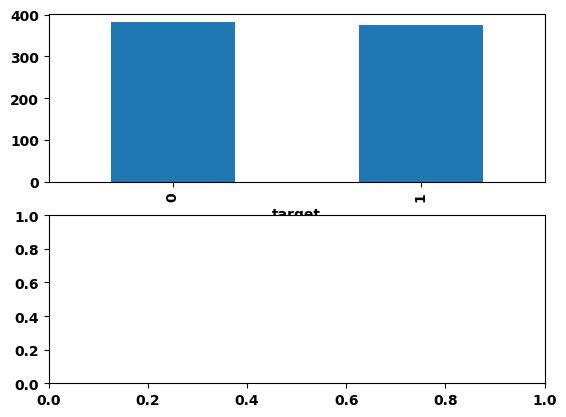

In [270]:
# create calculate target
df_target = df_cal.copy()

# calculate target
df_target["target"] = np.where(
    df_target['max_low_high_pct'] > zero_remover_pct,
    1,
    np.where(
        df_target['max_low_high_pct'] < -zero_remover_pct,
        -1, 0
    )
)

# convert -1 and 1 and 0 to True False for better result
df_target["target"] = np.where(df_target['target'] ==1, 1,0)
# df_target["target"] = np.where(df_target['target'] ==1, 1,-1)

# show chart
fig, axs = plt.subplots(2, 1)
df_target["target"].value_counts().plot(kind='bar', ax=axs[0])
# (np.sign(df_target["open_close"]) == np.sign(df_target["target"])).value_counts().plot(kind='bar',ax=axs[1])

# shift target the real place
df_target["target"] = df_target["target"].shift(-1)
# df_target

In [271]:
# clean data
df = df_target.copy()
df.dropna(inplace=True)
df.drop(columns=['open', 'high', 'low', 'close', 'volume', 'open_close', 'open_low', 'open_high',
                 'open_close_pct', 'open_low_pct', 'open_high_pct', 'max_low_high_pct'], inplace=True)
df

,open_close_pct__0,open_close_pct__1,open_close_pct__2,open_close_pct__3,open_close_pct__4,open_close_pct__5,open_close_pct__6,open_close_pct__7,open_close_pct__8,open_close_pct__9,...,max_low_high_pct__32,max_low_high_pct__33,max_low_high_pct__34,max_low_high_pct__35,max_low_high_pct__36,max_low_high_pct__37,max_low_high_pct__38,max_low_high_pct__39,max_low_high_pct__40,target
open_time,,,,,,,,,,,,,,,,,,,,,
2017-12-15 03:30:00,0.041014,0.336952,0.149449,-0.021448,-0.011043,0.084637,-0.088886,0.142730,0.102281,0.109360,...,-0.120282,-0.188084,-0.305756,-0.171721,0.134611,0.072607,0.083363,-0.501710,-0.076811,1.0
2017-12-18 03:30:00,0.116715,0.041014,0.336952,0.149449,-0.021448,-0.011043,0.084637,-0.088886,0.142730,0.102281,...,-0.346783,-0.120282,-0.188084,-0.305756,-0.171721,0.134611,0.072607,0.083363,-0.501710,0.0
2017-12-21 03:30:00,-0.194156,0.116715,0.041014,0.336952,0.149449,-0.021448,-0.011043,0.084637,-0.088886,0.142730,...,0.196219,-0.346783,-0.120282,-0.188084,-0.305756,-0.171721,0.134611,0.072607,0.083363,1.0
2017-12-24 03:30:00,0.171271,-0.194156,0.116715,0.041014,0.336952,0.149449,-0.021448,-0.011043,0.084637,-0.088886,...,-0.148311,0.196219,-0.346783,-0.120282,-0.188084,-0.305756,-0.171721,0.134611,0.072607,0.0
2017-12-27 03:30:00,-0.021347,0.171271,-0.194156,0.116715,0.041014,0.336952,0.149449,-0.021448,-0.011043,0.084637,...,0.141899,-0.148311,0.196219,-0.346783,-0.120282,-0.188084,-0.305756,-0.171721,0.134611,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-24 03:30:00,0.021473,0.100743,0.024843,0.006476,-0.007608,-0.040408,0.013060,-0.030450,-0.003029,0.046066,...,0.021396,-0.025420,-0.052931,0.070314,0.018483,-0.056911,0.026843,0.065956,-0.043312,0.0
2023-10-27 03:30:00,-0.004575,0.021473,0.100743,0.024843,0.006476,-0.007608,-0.040408,0.013060,-0.030450,-0.003029,...,0.020750,0.021396,-0.025420,-0.052931,0.070314,0.018483,-0.056911,0.026843,0.065956,1.0
2023-10-30 03:30:00,0.028884,-0.004575,0.021473,0.100743,0.024843,0.006476,-0.007608,-0.040408,0.013060,-0.030450,...,0.016332,0.020750,0.021396,-0.025420,-0.052931,0.070314,0.018483,-0.056911,0.026843,0.0


In [272]:
# analyse df
print("shape df: ", df.shape)
print(df.corr()['target'].sort_values(ascending=False))

shape df:  (718, 83)
target                  1.000000
open_close_pct__29      0.103132
max_low_high_pct__29    0.100581
open_close_pct__32      0.091655
max_low_high_pct__32    0.078357
                          ...   
open_close_pct__25     -0.049652
max_low_high_pct__18   -0.052614
open_close_pct__12     -0.055400
open_close_pct__33     -0.058700
open_close_pct__18     -0.060408
Name: target, Length: 83, dtype: float64


In [273]:
# create cross validator
# Data and targets
X, Y = df.iloc[:, :-1], df.iloc[:, -1]

In [274]:
# random x and y train and test
# x_train, x_test, y_train, y_test= train_test_split(
#     X, Y, test_size=.15, random_state=123
# )
# test faghat akharin vaziyat va na besorat random
test_point = int(len(X)*0.85)
x_train, x_test, y_train, y_test = X.iloc[:test_point,:],X.iloc[test_point:,:],Y.iloc[:test_point],Y.iloc[test_point:]
 
xgb_clf = xgb.XGBClassifier(random_state=123)
xgb_clf.get_params()
xgb_clf.set_params(n_estimators=500)
xgb_clf.fit(x_train, y_train)
y_preds = xgb_clf.predict(x_test)
accuracy = float(np.sum(y_preds==y_test))/y_test.shape[0]
print("Baseline accuracy:", accuracy)
print(metrics.classification_report(y_test,y_preds))

Baseline accuracy: 0.5462962962962963
              precision    recall  f1-score   support

         0.0       0.55      0.33      0.41        52
         1.0       0.55      0.75      0.63        56

    accuracy                           0.55       108
   macro avg       0.55      0.54      0.52       108
weighted avg       0.55      0.55      0.52       108


In [275]:
################################################
# yek noe digar baraye mohasebe
# cross validator
################################################

In [276]:
# model with cross validation
d_matrix = xgb.DMatrix(data=X, label=Y)
params = {
    'max_depth': 50 # count of tree in jungle
}
xgb_cv = xgb.cv(
    dtrain=d_matrix, 
    params=params, 
    nfold=5, # tedad ghesmatha baraye cross validation
    num_boost_round=10, # tedad max_depth agar model behtar nashod
    seed=123, # seed random baraye random haye moshabeh 
    metrics=['error'] # noe mohasebe baraye cross validation
)
xgb_cv

,train-error-mean,train-error-std,test-error-mean,test-error-std
0,0.0,0.0,0.509761,0.031199
1,0.0,0.0,0.505604,0.028653
2,0.0,0.0,0.507003,0.013441
3,0.0,0.0,0.513918,0.007270
4,0.0,0.0,0.508362,0.004723
5,0.0,0.0,0.515317,0.008421
6,0.0,0.0,0.515317,0.009469
7,0.0,0.0,0.518094,0.016387
8,0.0,0.0,0.519474,0.016514
9,0.0,0.0,0.516686,0.015734
